In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import json
import sys
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, matthews_corrcoef
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

In [2]:
path = "../input/archie-comics-multi-class/Multi-class/"

In [3]:
main_dir=os.listdir(path)

In [4]:
file_count = sum(len(files) for _, _, files in os.walk(path))
print(file_count)

6462


In [5]:
samples_per_class = []
classes = []

for each in main_dir:
    currentFolder = path + each
    count = sum(len(files) for _, _, files in os.walk(currentFolder))
    samples_per_class.append(count)
    classes.append(each)
    
print(samples_per_class)
print(classes)
num_classes = len(samples_per_class)
print(num_classes)
min_samples = min(samples_per_class)
print(min_samples)

[41, 71, 146, 85, 550, 962, 157, 67, 259, 34, 46, 33, 151, 109, 46, 679, 64, 121, 1284, 699, 39, 197, 622]
['Kleats', 'Midge', 'Dilton', 'Pop Tate', 'Reggie', 'Jughead', 'Grundy', 'Ethel', 'Weatherbee', 'Harry Clayton', 'Smithers', 'Svenson', 'Moose', 'Chuck', 'Nancy', 'Veronica', 'Flutesnoot', 'Fred Andrews', 'Archie', 'Betty', 'Beazley', 'Hiram Lodge', 'Others']
23
33


In [6]:
index_classes_dict = {k: v for v, k in enumerate(classes)}

In [7]:
index_classes_dict

{'Kleats': 0,
 'Midge': 1,
 'Dilton': 2,
 'Pop Tate': 3,
 'Reggie': 4,
 'Jughead': 5,
 'Grundy': 6,
 'Ethel': 7,
 'Weatherbee': 8,
 'Harry Clayton': 9,
 'Smithers': 10,
 'Svenson': 11,
 'Moose': 12,
 'Chuck': 13,
 'Nancy': 14,
 'Veronica': 15,
 'Flutesnoot': 16,
 'Fred Andrews': 17,
 'Archie': 18,
 'Betty': 19,
 'Beazley': 20,
 'Hiram Lodge': 21,
 'Others': 22}

In [8]:
index_classes_list = list(index_classes_dict.values())

In [9]:
inv_index_classes_dict = {v: k for k, v in index_classes_dict.items()}

In [10]:
inv_index_classes_dict

{0: 'Kleats',
 1: 'Midge',
 2: 'Dilton',
 3: 'Pop Tate',
 4: 'Reggie',
 5: 'Jughead',
 6: 'Grundy',
 7: 'Ethel',
 8: 'Weatherbee',
 9: 'Harry Clayton',
 10: 'Smithers',
 11: 'Svenson',
 12: 'Moose',
 13: 'Chuck',
 14: 'Nancy',
 15: 'Veronica',
 16: 'Flutesnoot',
 17: 'Fred Andrews',
 18: 'Archie',
 19: 'Betty',
 20: 'Beazley',
 21: 'Hiram Lodge',
 22: 'Others'}

In [11]:
inv_index_classes_list = list(inv_index_classes_dict.values())

In [12]:
batch_size = 8

In [13]:
train = tf.keras.preprocessing.image_dataset_from_directory(
        path,
        labels="inferred",
        label_mode="categorical",
        class_names=classes,
        validation_split=0.2,
        subset="training",
        shuffle=True,
        seed=123,
        batch_size=batch_size,
        image_size=(256, 256),
    )

Found 6462 files belonging to 23 classes.
Using 5170 files for training.


2022-07-02 20:47:33.011356: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-02 20:47:33.108509: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-02 20:47:33.109358: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-02 20:47:33.111565: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [14]:
valid = tf.keras.preprocessing.image_dataset_from_directory(
        path,
        labels="inferred",
        label_mode="categorical",
        class_names=classes,
        validation_split=0.2,
        subset="validation",
        shuffle=True,
        seed=123,
        batch_size=batch_size,
        image_size=(256, 256),
    )

Found 6462 files belonging to 23 classes.
Using 1292 files for validation.


In [15]:
stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        min_delta=0,
        patience=15,
        verbose=0,
        mode="auto",
        baseline=None,
        restore_best_weights=False,
    )

checkpoint = tf.keras.callbacks.ModelCheckpoint(
        "best_model",
        monitor="val_accuracy",
        mode="max",
        save_best_only=True,
        save_weights_only=True,
    )

In [16]:
base_model = tf.keras.applications.ResNet50(weights='imagenet', input_shape=(256, 256, 3), classes=num_classes, include_top = False)


# Based on https://pyimagesearch.com/2020/04/27/fine-tuning-resnet-with-keras-tensorflow-and-deep-learning/

# construct the head of the model that will be placed on top of the
# the base model
headModel = base_model.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(num_classes, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=base_model.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the training process
for layer in base_model.layers:
    layer.trainable = False
    
model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=tf.keras.losses.CategoricalCrossentropy(),#from_logits=True),
        metrics=["accuracy"]
    )
 
loss_0, acc_0 = model.evaluate(valid)
print(f"loss {loss_0}, acc {acc_0}")
    

history = model.fit(
        train,
        validation_data=valid,
        epochs=50,
        callbacks=[stopping, checkpoint]
)

model.load_weights("best_model")

loss, acc = model.evaluate(valid)
print(f"final loss {loss}, final acc {acc}")

94781440/94765736 [==============================] - 1s 0us/step


2022-07-02 20:47:40.245055: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-02 20:47:41.983848: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


162/162 [==============================] - 17s 50ms/step - loss: 4.1909 - accuracy: 0.0364
loss 4.190934658050537, acc 0.03637770935893059
Epoch 1/50
647/647 [==============================] - 42s 60ms/step - loss: 2.6484 - accuracy: 0.2348 - val_loss: 2.2415 - val_accuracy: 0.3158
Epoch 2/50
647/647 [==============================] - 29s 44ms/step - loss: 2.2567 - accuracy: 0.3335 - val_loss: 2.0482 - val_accuracy: 0.3901
Epoch 3/50
647/647 [==============================] - 28s 43ms/step - loss: 2.0554 - accuracy: 0.3870 - val_loss: 1.9296 - val_accuracy: 0.4249
Epoch 4/50
647/647 [==============================] - 29s 44ms/step - loss: 1.8892 - accuracy: 0.4340 - val_loss: 1.8480 - val_accuracy: 0.4396
Epoch 5/50
647/647 [==============================] - 29s 45ms/step - loss: 1.7553 - accuracy: 0.4663 - val_loss: 1.7716 - val_accuracy: 0.4582
Epoch 6/50
647/647 [==============================] - 29s 44ms/step - loss: 1.6331 - accuracy: 0.4988 - val_loss: 1.6926 - val_accuracy: 0.48

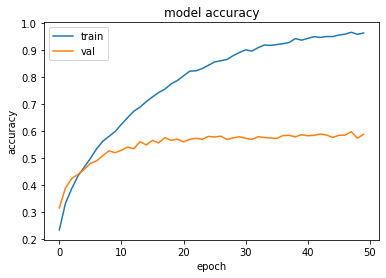

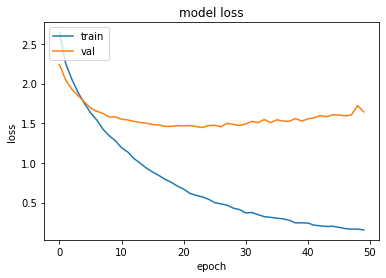

In [17]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [18]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in valid:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
correct_labels = np.argmax(correct_labels,axis=1)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [19]:
names_correct_labels = np.vectorize(inv_index_classes_dict.get)(correct_labels)

In [20]:
names_predicted_labels = np.vectorize(inv_index_classes_dict.get)(predicted_labels)

In [21]:
names_correct_labels[600:620]

array(['Archie', 'Dilton', 'Jughead', 'Reggie', 'Chuck', 'Veronica',
       'Kleats', 'Hiram Lodge', 'Others', 'Betty', 'Moose', 'Archie',
       'Betty', 'Archie', 'Veronica', 'Pop Tate', 'Reggie', 'Others',
       'Others', 'Veronica'], dtype='<U13')

In [22]:
names_predicted_labels[600:620]

array(['Archie', 'Others', 'Jughead', 'Reggie', 'Chuck', 'Veronica',
       'Weatherbee', 'Hiram Lodge', 'Betty', 'Betty', 'Archie', 'Midge',
       'Grundy', 'Archie', 'Veronica', 'Jughead', 'Reggie', 'Reggie',
       'Others', 'Veronica'], dtype='<U12')

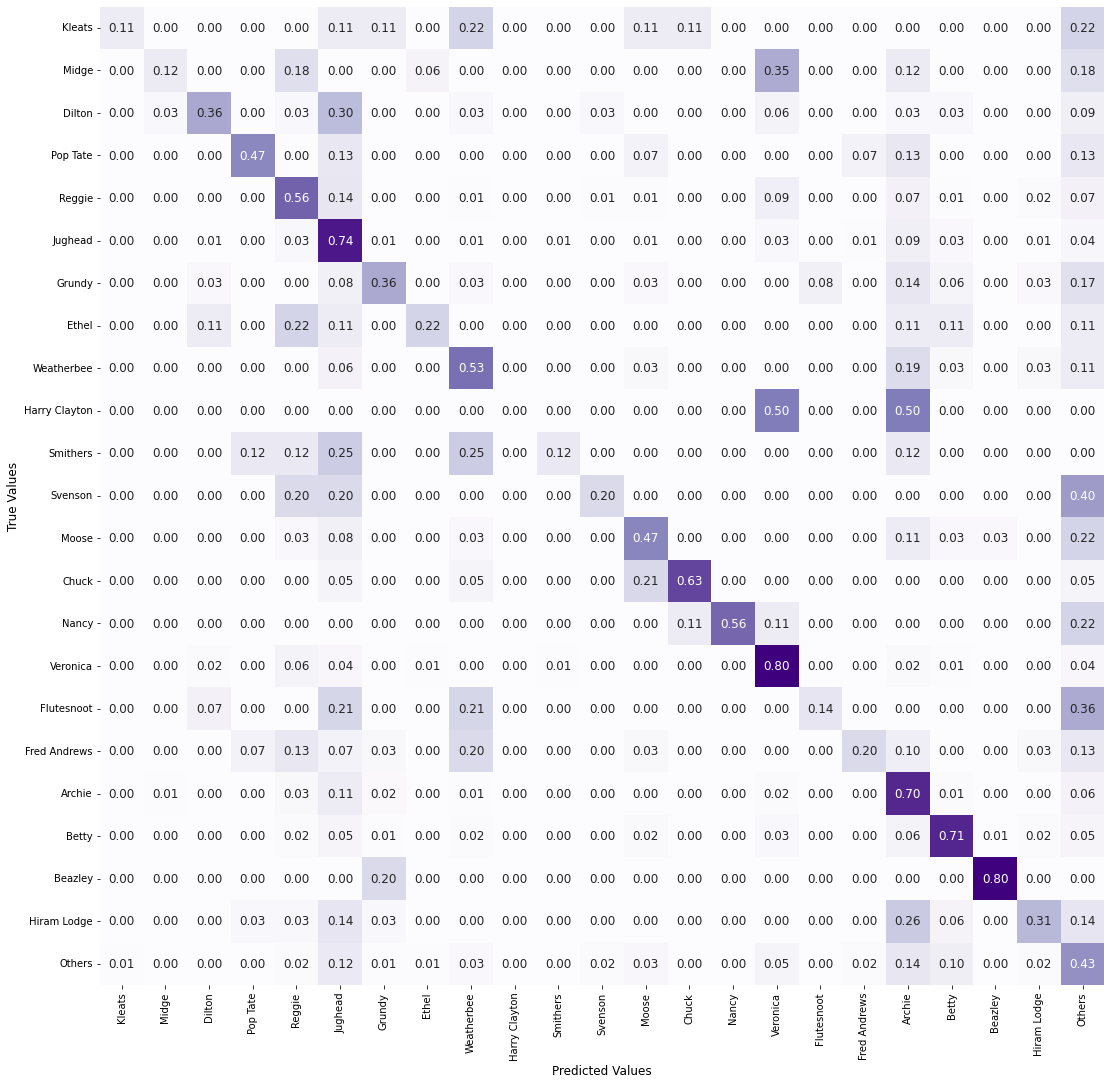

In [23]:
cm = confusion_matrix(correct_labels, predicted_labels, labels=index_classes_list, normalize='true')
fig = plt.figure(figsize = (18,18))
ax1 = fig.add_subplot(1,1,1)
sns.set(font_scale=1.2) #for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 12},
     cbar = False, cmap='Purples', fmt='.2f', 
            xticklabels=inv_index_classes_list, yticklabels=inv_index_classes_list);
ax1.set_ylabel('True Values',fontsize=12)
ax1.set_xlabel('Predicted Values',fontsize=12)
plt.show()

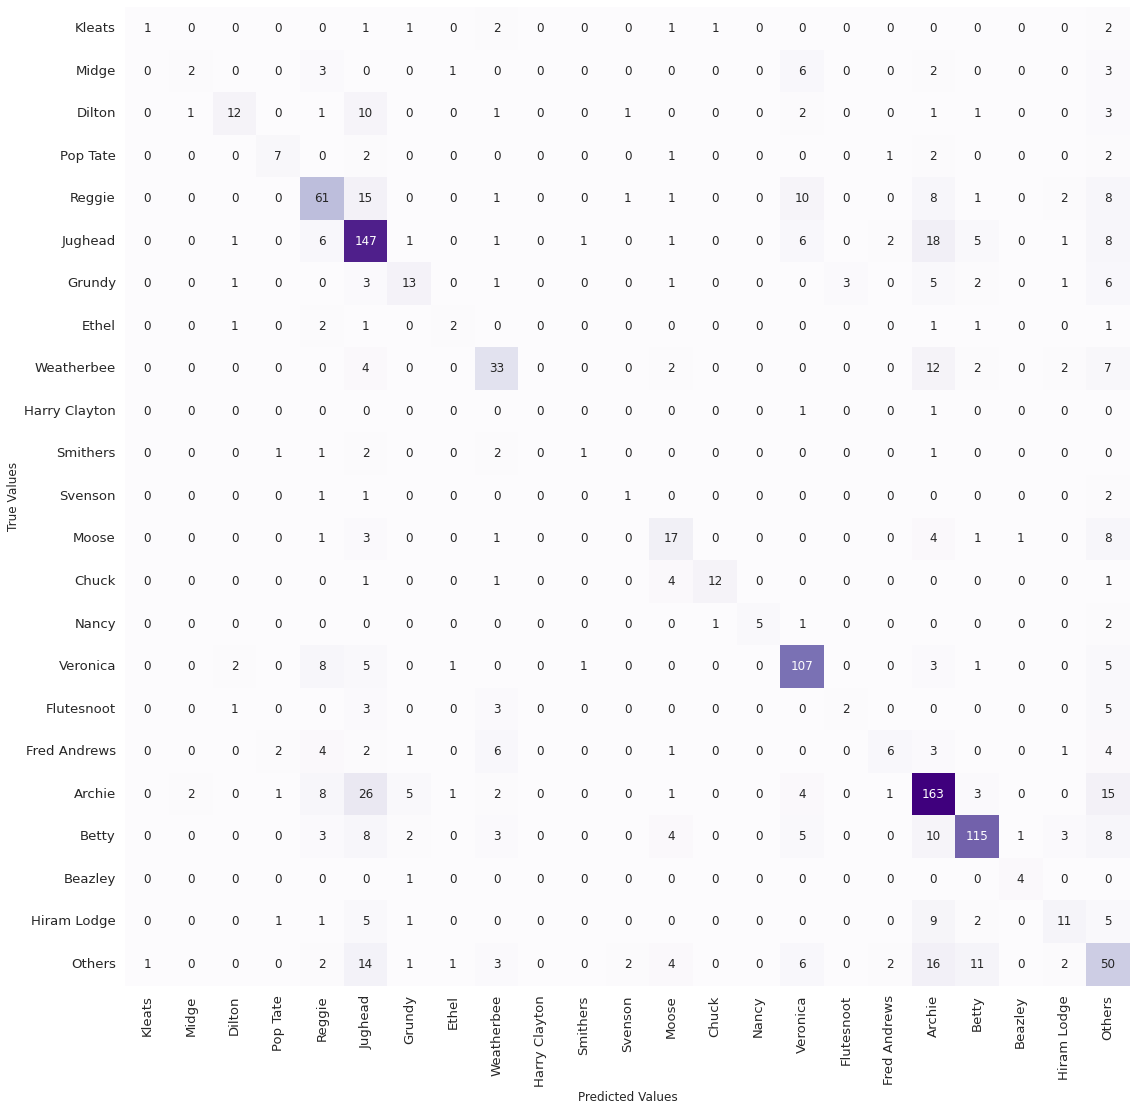

In [24]:
cm = confusion_matrix(correct_labels, predicted_labels, labels=index_classes_list)
fig = plt.figure(figsize = (18,18))
ax1 = fig.add_subplot(1,1,1)
sns.set(font_scale=1.2) #for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 12},
     cbar = False, cmap='Purples', fmt='d',
           xticklabels=inv_index_classes_list, yticklabels=inv_index_classes_list);
ax1.set_ylabel('True Values',fontsize=12)
ax1.set_xlabel('Predicted Values',fontsize=12)
plt.show()

In [25]:
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
FP = cm.sum(axis=0) - np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# from https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
TPR[18]

0.7025862068965517

In [26]:
# Precision or positive predictive value
PPV = TP/(TP+FP)
PPV[18]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


0.6293436293436293

In [27]:
F1 = TP/(TP+(FP+FN)/2)

<AxesSubplot:xlabel='No. of samples', ylabel='True positive rate'>

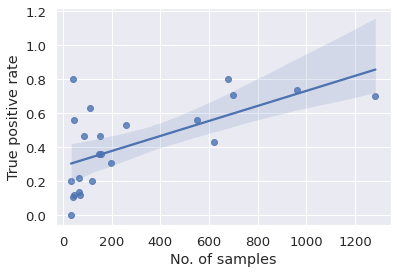

In [28]:
df_from_arr = pd.DataFrame(data=[samples_per_class, TPR]).T
df_from_arr.rename(columns={0: "No. of samples", 1: "True positive rate"}, inplace = True)
df_from_arr.index = classes
df_from_arr["No. of samples"] = df_from_arr["No. of samples"].astype(int)
df_from_arr["True positive rate"] = df_from_arr["True positive rate"].round(2)

sns.regplot(data=df_from_arr, x="No. of samples", y="True positive rate")

In [29]:
df_from_arr_2 = pd.DataFrame(data=[samples_per_class, TP, FP, TN, FN, F1]).T
df_from_arr_2.rename(columns={0: "No. of samples", 1: "True positives", 2: "False positives",
                           3: "True negatives", 4: "False negatives", 5: "F1 score"}, inplace = True)
df_from_arr_2.index = classes
df_from_arr_2["F1 score"] = df_from_arr_2["F1 score"].round(2)

#Total sum per column: 
df_from_arr_2.loc['Total']= df_from_arr_2.sum(axis=0)
df_from_arr_2.iloc[-1,-1]= np.nan

print(df_from_arr_2)

               No. of samples  True positives  False positives  \
Kleats                   41.0             1.0              1.0   
Midge                    71.0             2.0              3.0   
Dilton                  146.0            12.0              6.0   
Pop Tate                 85.0             7.0              5.0   
Reggie                  550.0            61.0             41.0   
Jughead                 962.0           147.0            106.0   
Grundy                  157.0            13.0             13.0   
Ethel                    67.0             2.0              4.0   
Weatherbee              259.0            33.0             27.0   
Harry Clayton            34.0             0.0              0.0   
Smithers                 46.0             1.0              2.0   
Svenson                  33.0             1.0              4.0   
Moose                   151.0            17.0             21.0   
Chuck                   109.0            12.0              2.0   
Nancy     

In [30]:
macro_F1 = round(df_from_arr_2["F1 score"].mean(),2)
macro_F1

0.45

In [31]:
micro_F1 = df_from_arr_2.iloc[-1,1]/(df_from_arr_2.iloc[-1,1]+0.5*(df_from_arr_2.iloc[-1,2]+df_from_arr_2.iloc[-1,4]))
micro_F1 = round(micro_F1,2)
micro_F1

0.6

In [32]:
print(df_from_arr_2.to_markdown()) 

|               |   No. of samples |   True positives |   False positives |   True negatives |   False negatives |   F1 score |
|:--------------|-----------------:|-----------------:|------------------:|-----------------:|------------------:|-----------:|
| Kleats        |               41 |                1 |                 1 |             1282 |                 8 |       0.18 |
| Midge         |               71 |                2 |                 3 |             1272 |                15 |       0.18 |
| Dilton        |              146 |               12 |                 6 |             1253 |                21 |       0.47 |
| Pop Tate      |               85 |                7 |                 5 |             1272 |                 8 |       0.52 |
| Reggie        |              550 |               61 |                41 |             1143 |                47 |       0.58 |
| Jughead       |              962 |              147 |               106 |              988 |          

In [33]:
MCC = matthews_corrcoef(correct_labels, predicted_labels)

In [34]:
MCC

0.5471696211550227